# New York City AirBnB Open Data | Kaggle

This dataset was taken from <a href="https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/">kaggle</a> as one of my first data practices.

## Context and Acknowledgements 
This data file includes all needed information to find out more about hosts, geographical availability, necessary metrics to make predictions and draw conclusions. This public dataset is part of Airbnb, and the original source can be found on this website.

## Inspiration
* What can we learn about different hosts and areas?
* What can we learn from predictions? (ex: locations, prices, reviews, etc)
* Which hosts are the busiest and why?
* Is there any noticeable difference of traffic among different areas and what could be the reason for it?

## Data we don't have (unfortunately)
* Rating (Overall) + Rating Breakdown (Cleanliness, Location, Communication, etc.)
* Change in Price or price over time
* Active or Not Active - A proxy can be recency of last review being over 6 months
* Total Transactions - A proxy can be number of reviews
* Total Nights Stayed - A proxy can be number of reviews * minimum nights

## Data Cleaning

In [2]:
### Import Libraries
# Analysis
import pandas as pd
import numpy as np

import time

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from folium.plugins import HeatMap
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from PIL import Image

ModuleNotFoundError: No module named 'wordcloud'

In [3]:
df = pd.read_csv("data/AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [6]:
df.last_review = pd.to_datetime(df.last_review)
# Find date range of data
print(df.last_review.min(), df.last_review.max())

2011-03-28 00:00:00 2019-07-08 00:00:00


In [7]:
# Change room_type to ordinal/categorical
room_type_list = ['Shared room','Private room','Entire home/apt']
ordered_room_type = pd.api.types.CategoricalDtype(ordered = True, categories = room_type_list)
df.room_type = df.room_type.astype(ordered_room_type)

In [8]:
# Change neighbourhood_group to nominal/categorical
neighbourhood_group_list = list(df.neighbourhood_group.unique())
neighbourhood_group_category = pd.api.types.CategoricalDtype(categories = neighbourhood_group_list)
df.neighbourhood_group = df.neighbourhood_group.astype(neighbourhood_group_category)

In [9]:
# Add distance from Times Square as a feature as it is the most visited landmark in NYC
def ts_distance(lat, long):
    ts_latitude = 40.7590
    ts_longitude = 73.9845
    # Get Pythagorean distance
    return ((ts_latitude - lat)**2 + (ts_longitude - long)**2)**.5

df["distance_from_ts"] = df.apply(lambda x: ts_distance(x.latitude, x.longitude), axis=1)

In [10]:
# Add recency of last review as a feature
latest_date = df.last_review.max()
df["recency"] = df.last_review.apply(lambda x: (latest_date - x).days)

In [11]:
# Add a proxy for number of nights stayed
df["total_nights"] = df.apply(lambda x: x.minimum_nights * x.number_of_reviews, axis=1)

## Data Exploration

### Plot the AirBnB traffic by neighbourhoods

There are 5 neighbourhood groups: Brooklyn, Manhattan, Queens, Staten Island, and Bronx. 

/Users/sarinachen/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


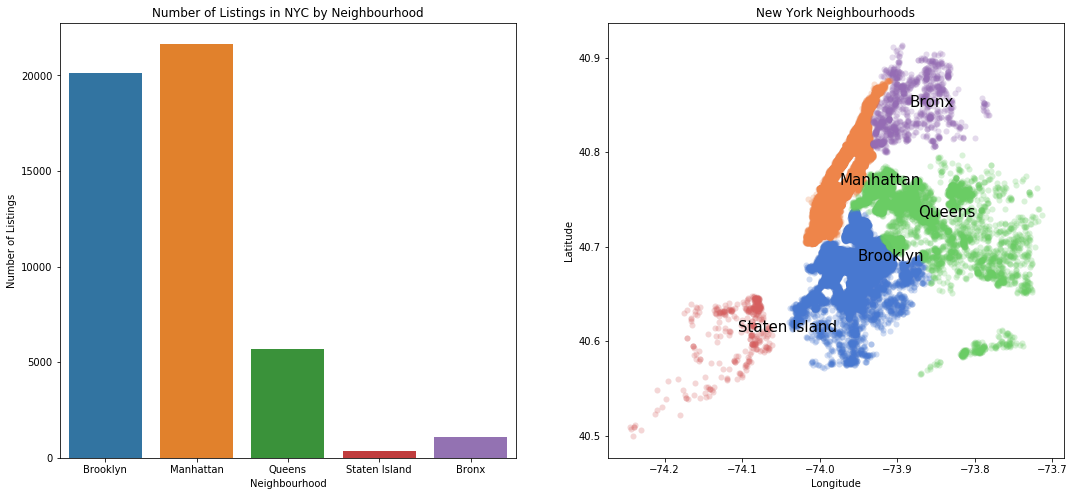

In [12]:
fig, ax = plt.subplots(1,2,figsize=(18,8))

# Create countplot
sns.countplot(data=df, x="neighbourhood_group", ax = ax[0]);
ax[0].set_title("Number of Listings in NYC by Neighbourhood");
ax[0].set_ylabel("Number of Listings");
ax[0].set_xlabel("Neighbourhood");

# Create map (scatterplot)
g = sns.FacetGrid(data = df, hue = 'neighbourhood_group', size = 6, palette=sns.color_palette('muted',n_colors=5));
g.map(ax[1].scatter,'longitude','latitude', alpha = .25, linewidth=.01);
ax[1].set_title("New York Neighbourhoods");
ax[1].set_ylabel("Latitude");
ax[1].set_xlabel("Longitude");
# Add labels
n = df[["neighbourhood_group","longitude","latitude"]].groupby(["neighbourhood_group"]).mean().reset_index()
for i in range(n.shape[0]):
    ax[1].text(n.longitude[i], n.latitude[i], n.neighbourhood_group[i], color='black', size=15);
    
plt.close();

In [13]:
# View on Heat Map
m=folium.Map([40.7128,-74.0060],zoom_start=11)
HeatMap(df[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)
display(m)

Manhattan as the busiest neighbourhood group, followed by Brooklyn, Queens, Bronx, and Staten Island.

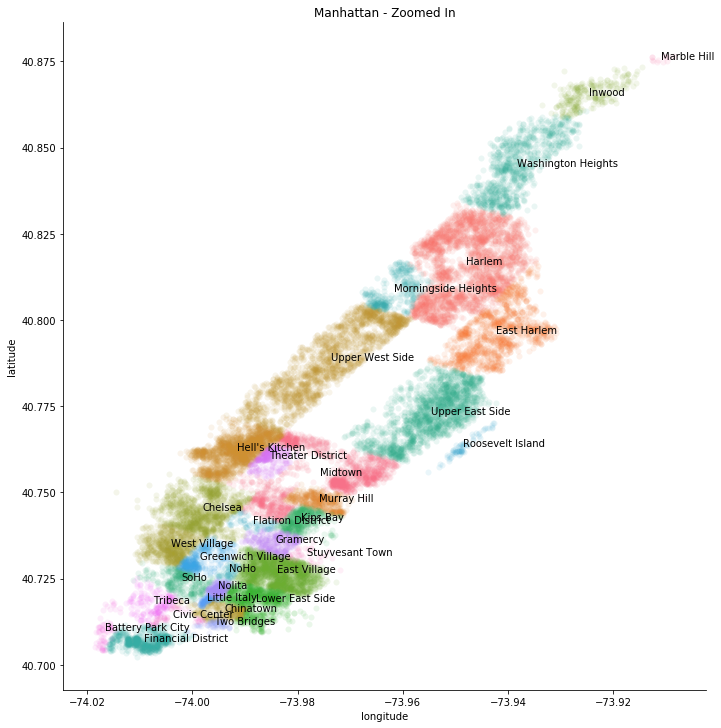

In [13]:
# Plot Manhattan neighbourhoods
g = sns.FacetGrid(data = df[df.neighbourhood_group=="Manhattan"], hue = 'neighbourhood', size = 10)
g.map(plt.scatter,'longitude','latitude', alpha = .1, linewidth=.01);
plt.title("Manhattan - Zoomed In");
# Add labels
n = df[df.neighbourhood_group=="Manhattan"].groupby(["neighbourhood"]).mean()[["longitude","latitude"]].reset_index()
for i in range(n.shape[0]):
    plt.text(n.longitude[i], n.latitude[i], n.neighbourhood[i]);

Hell's Kitchen, East Village, Lower East Side, and Financial District have a lot of traffic. Many tourist places and restaurants including Times Square are located in Hell's Kitchen, leading to the expected high AirBnb traffic. Financial District could be where many guests stay for business. 

### Explore Prices

The average price in NYC is 122.


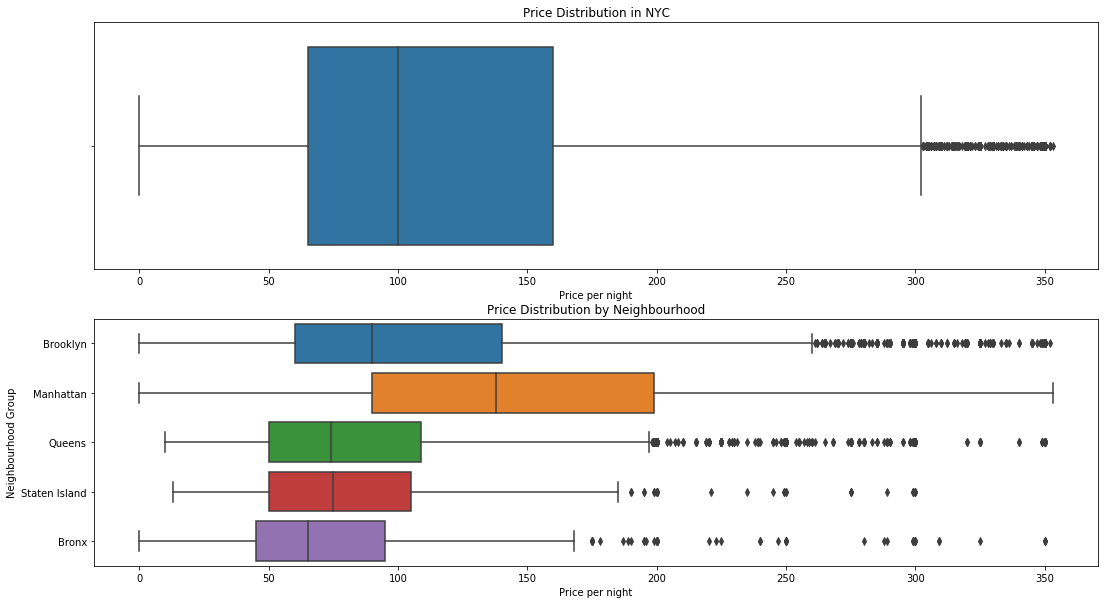

In [14]:
fig, ax = plt.subplots(2,1, figsize=(18,10))
d = df[df.price < df.price.quantile(.95)] # Remove top 5% which are outliers

# Plot price distribution in NYC
plt.sca(ax[0])
sns.boxplot(data=d, x = "price");
plt.title("Price Distribution in NYC");
plt.xlabel("Price per night");

plt.sca(ax[1])
# Plot price distribution by neighbourhood
sns.boxplot(data=d, x = "price", y = "neighbourhood_group");
plt.xlabel("Price per night");
plt.ylabel("Neighbourhood Group");
plt.title("Price Distribution by Neighbourhood");

print("The average price in NYC is {}.".format(int(d.price.mean())))

The median price per night is between 50 and 100 for all neighbourhoods except for Manhattan. All distributions are skewed right, such that the average price is higher than their median price. 

Staten Island has the least amount of traffic yet it does not have the cheapest average price. Manhattan has the highest traffic and significantly higher price. Bronx is the cheapest and has relatively lower traffic than Queens, Brooklyn, and Manhattan.

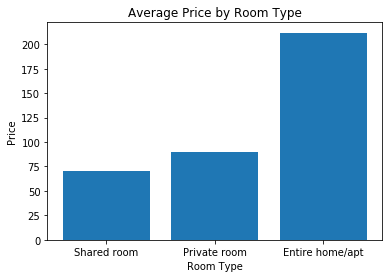

In [15]:
# Explore by room type
p = df.groupby(["room_type"]).mean().price.reset_index().sort_values(by="price")
plt.bar(data=p, x = "room_type" , height = "price");
plt.ylabel("Price");
plt.xlabel("Room Type");
plt.title("Average Price by Room Type");

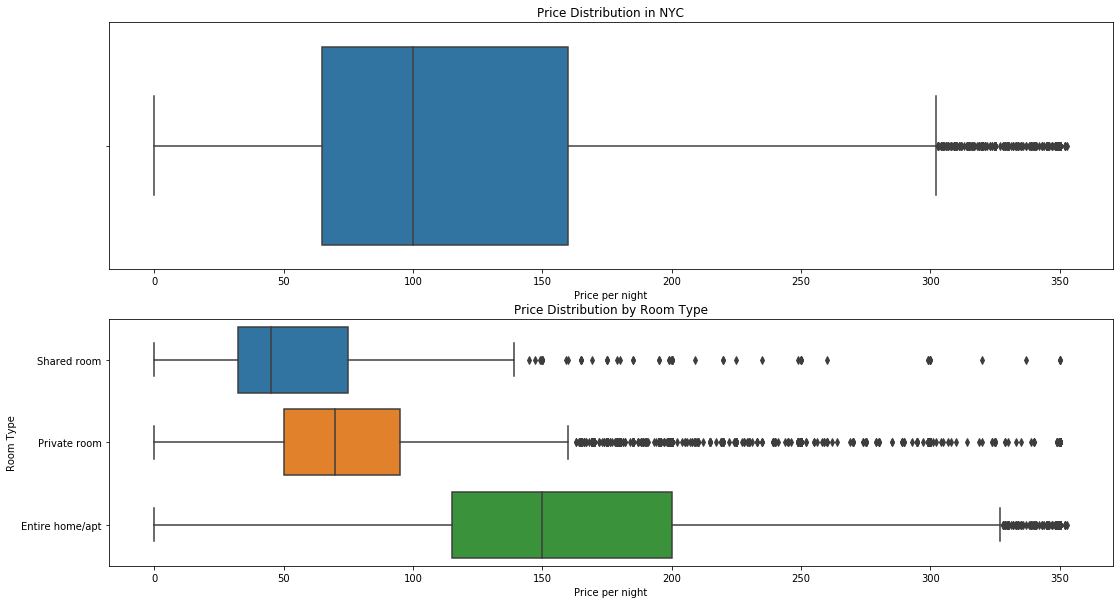

In [16]:
fig, ax = plt.subplots(2,1, figsize=(18,10))
d = df[df.price < df.price.quantile(.95)] # Remove top 5% which are outliers

# Plot price distribution in NYC
plt.sca(ax[0])
sns.boxplot(data=d, x = "price");
plt.title("Price Distribution in NYC");
plt.xlabel("Price per night");

plt.sca(ax[1])
# Plot price distribution by neighbourhood
sns.boxplot(data=d, x = "price", y = "room_type");
plt.xlabel("Price per night");
plt.ylabel("Room Type");
plt.title("Price Distribution by Room Type");

There are very few shared rooms in NYC compared to private rooms and entire homes. However, shared rooms are extremely cheap given lower quality standards (I've stayed in a quad for 60 per night before). There are many entire homes/apts on AirBnB with a much higher price tag, but maybe people come to New York to have fun and splurge a little.

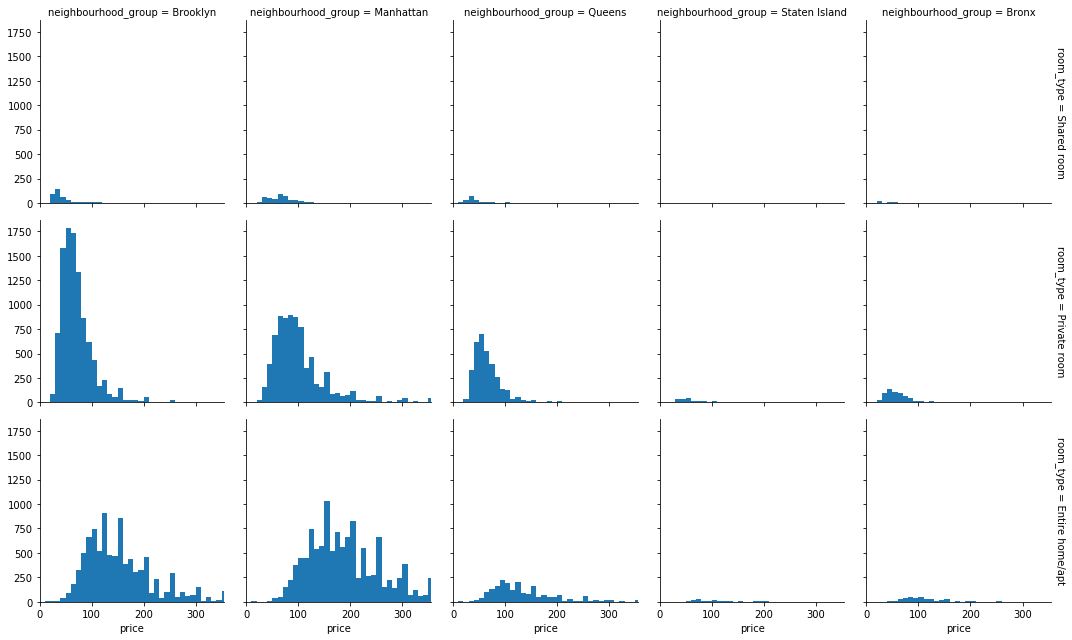

In [17]:
g = sns.FacetGrid(data = df, col = 'neighbourhood_group', row="room_type", margin_titles = True)
g.map(plt.hist, 'price',bins=np.arange(0,df.price.max(),10))
# Limit price cap to 95th percentile
plt.xlim(0,df.price.quantile(.95));

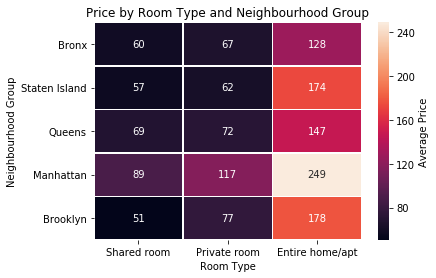

In [18]:
# Explore Price by Room Type and Neighbourhood Group
price_pivot = df.groupby(['neighbourhood_group', 'room_type']).mean()['price'].reset_index(name = 'average_price')
price_pivot = price_pivot.pivot(index = 'neighbourhood_group', columns = 'room_type', values = 'average_price')
sns.heatmap(price_pivot, annot = True, fmt = '.0f', cbar_kws = {'label' : 'Average Price'},linewidths=.5);
plt.xlabel("Room Type");
plt.ylabel("Neighbourhood Group");
plt.title("Price by Room Type and Neighbourhood Group");
plt.ylim(0,5);

As room quality increases, price increases. Manhattan is the most expensive neighbourhood, as it has the most things to do.

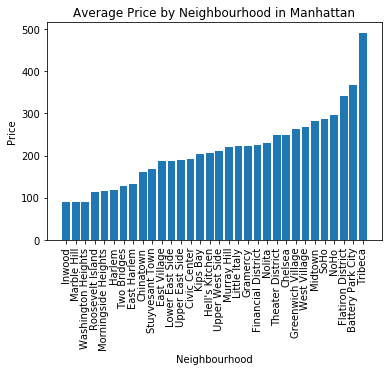

In [19]:
# Zoom in prices in Manhattan
p = df[df.neighbourhood_group=="Manhattan"].groupby(["neighbourhood"]).mean().price.reset_index().sort_values(by="price")
plt.bar(data=p, x = "neighbourhood" , height = "price");
plt.ylabel("Price");
plt.xlabel("Neighbourhood");
plt.xticks(rotation=90);
plt.title("Average Price by Neighbourhood in Manhattan");

Tribeca is the most expensive, but it also doesn't have the highest traffic. Inwood and Marble Hill are the cheapest, but they also have the least traffic due to being far from everything. 

Financial District, Hell's Kitchen, East Village, and Lower East Side are within the same range, close to the Manhattan AirBnB price average (likely because they have the most weight).

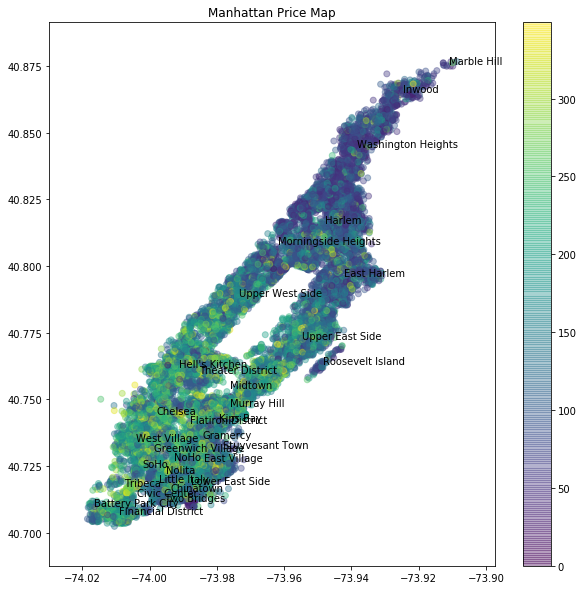

In [20]:
# Plot Manhattan neighbourhoods
plt.figure(figsize=[10,10])
plt.scatter(data = df[(df.neighbourhood_group=="Manhattan") & (df.price < 350)],x='longitude',y='latitude', c="price", alpha=.4);
plt.title("Manhattan Price Map");
plt.colorbar();
# Add labels
n = df[(df.neighbourhood_group=="Manhattan") & (df.price < 350)].groupby(["neighbourhood"]).mean()[["longitude","latitude"]].reset_index()
for i in range(n.shape[0]):
    plt.text(n.longitude[i], n.latitude[i], n.neighbourhood[i]);

In [21]:
# Plot other correlations on price
df.iloc[:,8:].corr()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance_from_ts,recency,total_nights
price,1.000000,0.042799,-0.047954,-0.030608,0.057472,0.081829,0.149984,0.016811,-0.003916
minimum_nights,0.042799,1.000000,-0.080116,-0.121702,0.127960,0.144303,0.062732,0.052803,0.277607
number_of_reviews,-0.047954,-0.080116,1.000000,0.549868,-0.072376,0.172028,-0.059087,-0.283000,0.244725
reviews_per_month,-0.030608,-0.121702,0.549868,1.000000,-0.009421,0.185791,-0.145938,-0.441489,0.074160
calculated_host_listings_count,0.057472,0.127960,-0.072376,-0.009421,1.000000,0.225701,0.114685,-0.050702,-0.018406
availability_365,0.081829,0.144303,0.172028,0.185791,0.225701,1.000000,-0.082710,-0.319512,0.061729
distance_from_ts,0.149984,0.062732,-0.059087,-0.145938,0.114685,-0.082710,1.000000,0.105665,0.009202
recency,0.016811,0.052803,-0.283000,-0.441489,-0.050702,-0.319512,0.105665,1.000000,-0.052581
total_nights,-0.003916,0.277607,0.244725,0.074160,-0.018406,0.061729,0.009202,-0.052581,1.000000


There are no strong correlations on price with numerical/continuous variables. Distance form Times Square may not be a good indicator of price and is a proxy for neighbourhoods. 

There are other correlations between reviews per month and total number of reviews, suggesting that the frequency is higher if those 2 variables are higher. 

### Look at Host Details

In [22]:
p = df.host_id.value_counts().reset_index(name="number_of_listings")
percent = p[p.number_of_listings > 1].shape[0] / p.shape[0]
print("{:0.1f}% of hosts have more than 1 listing".format(percent*100))

13.8% of hosts have more than 1 listing


In [23]:
number_of_listings = pd.DataFrame(df.groupby("host_id").count()["id"])
number_of_reviews = pd.DataFrame(df.groupby("host_id").sum()["number_of_reviews"])
p = number_of_listings.join(number_of_reviews)
p.rename(columns = {"id":"number_of_listings"}, inplace=True)

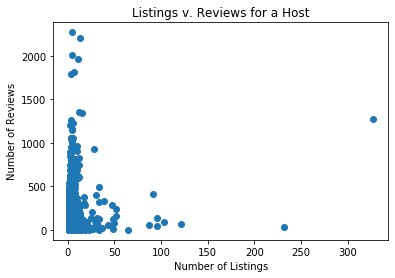

In [24]:
plt.scatter(data = p, x = "number_of_listings",y = "number_of_reviews");
plt.title("Listings v. Reviews for a Host");
plt.xlabel("Number of Listings");
plt.ylabel("Number of Reviews");

In [25]:
# Get list of hosts with more than 100 listings
hosts = pd.DataFrame(p[p.number_of_listings > 100].reset_index()["host_id"])

hosts_listings = df.merge(hosts, how="inner")
p = hosts_listings.sample(20).sort_values(by="host_id")
for i in range(len(p)):
    print(p.host_name.iloc[i] + ": " + p.name.iloc[i])

Kara: Stunning 4 Bed Tribeca Penthouse w/ Huge Terrace!
Kara: -Luxury NYC 1 Bedroom nearby Theater District!
Blueground: Charming West Village Studio w/ Gym + Doorman by Blueground
Blueground: Hip Midtown West 2BR w/ roomy sundeck, gym, near Times Sq by Blueground
Blueground: Gorgeous + Bright Midtown East 1BR, Doorman, Gym by Blueground
Kazuya: Lovely Room in Sunnsyide, 15 min ride to Manhattan
Kazuya: Affordable room near airport - LGA - and subway!
Kazuya: Astoria Couples RM w/ Lovely Furniture. Own bath.
Kazuya: Spacious room with easy commute to Grand Central!
Kazuya: Room for easy commute. Near train & essentials!
Sonder (NYC): Sonder | Stock Exchange | Tasteful 3BR + Laundry
Sonder (NYC): Sonder | Stock Exchange | Smart 1BR + Laundry
Sonder (NYC): Sonder | The Biltmore | Spacious 1BR + Kitchen
Sonder (NYC): Sonder | The Nash | Alluring Studio + Rooftop
Sonder (NYC): Sonder | 116 John | Quaint Studio + Gym
Sonder (NYC): Sonder | Stock Exchange | Unique 1BR + Laundry
Sonder (NYC):

These hosts own multiple properties with the same type of housing and name format. They seem to belong to companies ("Sonder" or "Blueground"). 

### See what words are used the most in listings

Generate a word cloud based on commonly used words.

In [26]:
# Upload house mask
house = np.array(Image.open("images/House.png"))

def transform_format(val):
    # Change all 0 values to 255 (white) for the mask to show up properly in wordcloud
    if val == 0:
        return 255
    else:
        return val

transformed_house = np.ndarray((house.shape[0],house.shape[1]), np.int32)

for i in range(len(transformed_house)):
    transformed_house[i] = list(map(transform_format, transformed_house[i]))

transformed_house = transformed_house[50:551,100:601]

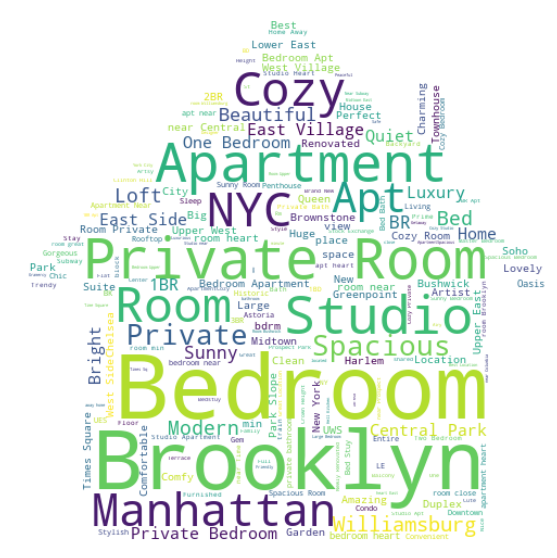

In [27]:
text = "".join(str(each) for each in df.name) # Separate all words with a space

# Generate word cloud image
wordcloud = WordCloud(max_words=200, mask = transformed_house, background_color="white")
# Generate word cloud text
wordcloud.generate(text)

# Display the generated image:
plt.figure(figsize=(10,10));
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off");
plt.show();

Hosts tend to specify the room type, neighbourhood, and just the fact that it's a room. There are positive characteristics such as "Charming", "Spacious", "Garden", "Luxury", and "Comfy".

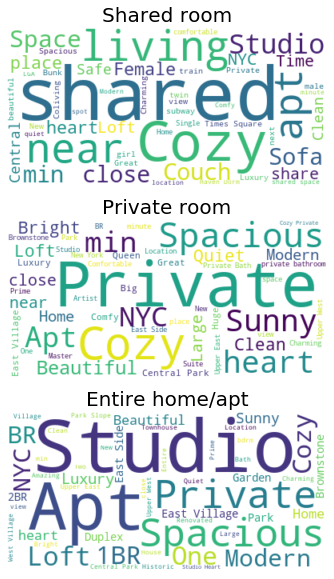

In [28]:
# Remove all neighbourhoods from the wordcloud
stopwords = set(STOPWORDS)
stopwords.update(df.neighbourhood.unique(), df.neighbourhood_group.unique())
stopwords.update(["bed","room","bedroom","apartment"])

# Create plots
fig, ax = plt.subplots(3,1, figsize=(18,10))

for i in range(len(room_type_list)):
    plt.sca(ax[i])
    d = df[df.room_type == room_type_list[i]] # Query for only rows with specified room type
    text = "".join(str(each) for each in d.name) # Create text

    wordcloud = WordCloud(max_words=50, background_color="white", stopwords = stopwords) # Generate word cloud image
    wordcloud.generate(text) # Generate word cloud text
    plt.imshow(wordcloud, interpolation='bilinear'); # Display the generated image:
    plt.axis("off");
    plt.title(room_type_list[i], size=20);

plt.show();

Listings tend to have their room type in their name. All of them share the common word "cozy".

Shared rooms have "couch", "living room", "loft", and gender ("girl", "male"). Private rooms say "private", "sunny", "beautiful", and "quiet. Entire homes say "spacious", "luxury", "garden", and "modern". 

Both shared rooms and private rooms have words describing proximity ("near", "close", "min"). Entire homes seem to focus more on quality and luxury.